## Demonstration of Spoken Digits Classification

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Data-Driven Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook demonstrates the classification of recorded spoken digits in the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset) (FSDD). Please download/clone the dataset before executing this notebook. Mel-Frequency Cepstral Coefficients (MFCCs) are used as two-dimensional features which are fed into a convolutive neural network (CNN) for classification.

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from librosa.feature import mfcc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Activation, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path = '../data/free-spoken-digit-dataset/recordings/'  # path to dataset

### Load Dataset

The FSDD consists of a series of wav files containing recordings of the single spoken digits `0-9` for different individuals. Each digit has been recorded multiple times for each individual. In the following, all samples in the database are loaded, normalized and truncated to a common length.

In [3]:
def load_examples(path):

    X = list()
    Y = list()

    audiofiles = glob.glob(path, recursive=True)
    for filepath in audiofiles:
        x, fs = sf.read(filepath)
        x = x / np.max(np.abs(x))
        X.append(x)
        Y.append(int(os.path.basename(filepath)[0]))

    return X, Y, fs


# load examples
X_raw, Y, fs = load_examples(path + '*.wav')

# determine maximum length of the examples
lengths = [len(x) for x in X_raw]
F = np.max(lengths)

# append zeros to examples to equalize lengths
X_raw = [np.concatenate((sample, np.zeros(F - len(sample))))
         for sample in X_raw]
X_raw = np.array(X_raw)
Y = np.array(Y)

# one-hot encoding of class labels
Y1h = to_categorical(Y, 10)

In [4]:
print('Total number of examples: {}'.format(len(X_raw)))
print('Number of samples per example: {}'.format(F))

Total number of examples: 3000
Number of samples per example: 18262


### Feature Extraction

Now the MFCCs for each example are computed.

In [5]:
X = [mfcc(y=sample, sr=fs, htk=True) for sample in X_raw]
X = np.array(X)

print('Total number of examples: {}'.format(X.shape[0]))
print('Dimension of feature vectors: {}'.format(X.shape[1:]))

Total number of examples: 3000
Dimension of feature vectors: (20, 36)


### Define and Train the Model

The model is defined as a concatenation of an input layer, two-dimensional convolutional layers, activation layers, pooling layers and an output layer. For the model, the output shapes of the individual layers, as well as the number of parameters that have to be determined in the training phase are summarized.

In [6]:
def dnn_model(input_shape=(20,36,1), classes=10):

    inputs = Input(shape=input_shape)

    z = Conv2D(8, (3,3))(inputs)
    z = Activation('relu')(z)
    z = MaxPooling2D((2,2))(z)
    z = Conv2D(16, (3,3))(z)
    z = Activation('relu')(z)
    z = MaxPooling2D((2,2))(z)
    
    z = Flatten()(z)
    z = Dense(classes, activation='softmax')(z)

    return Model(inputs, z)


model = dnn_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 36, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 18, 34, 8)         80        
                                                                 
 activation (Activation)     (None, 18, 34, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 17, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 15, 16)         1168      
                                                                 
 activation_1 (Activation)   (None, 7, 15, 16)         0         
                                                             

Now the model is compiled and trained. We used the `categorical crossentropy` as loss and the `Adam` optimizer. As evaluation metrics, the accuracy of the prediction is used. The examples are split into a set of examples used for training and a set used for validation of the trained model. The loss and the accuracy is plotted for each epoch for both the training and validation subsets. Early stopping is used to prevent overfitting of the model.

In [7]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y1h, test_size=0.2)

callback = EarlyStopping(monitor='accuracy', patience=15)
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), callbacks=[callback], epochs=200, batch_size=128)

Epoch 1/200
19/19 [==============================] - 1s 23ms/step - loss: 28.0871 - accuracy: 0.1300 - val_loss: 9.8694 - val_accuracy: 0.1933
Epoch 2/200
19/19 [==============================] - 0s 17ms/step - loss: 6.0116 - accuracy: 0.1442 - val_loss: 3.9918 - val_accuracy: 0.2433
Epoch 3/200
19/19 [==============================] - 0s 17ms/step - loss: 3.3903 - accuracy: 0.2296 - val_loss: 2.6992 - val_accuracy: 0.2733
Epoch 4/200
19/19 [==============================] - 0s 19ms/step - loss: 2.5204 - accuracy: 0.3029 - val_loss: 2.1870 - val_accuracy: 0.3417
Epoch 5/200
19/19 [==============================] - 0s 13ms/step - loss: 2.0657 - accuracy: 0.3592 - val_loss: 1.8102 - val_accuracy: 0.4000
Epoch 6/200
19/19 [==============================] - 0s 13ms/step - loss: 1.7394 - accuracy: 0.4283 - val_loss: 1.5382 - val_accuracy: 0.4717
Epoch 7/200
19/19 [==============================] - 0s 12ms/step - loss: 1.4732 - accuracy: 0.4992 - val_loss: 1.3141 - val_accuracy: 0.5550
Epoch

19/19 [==============================] - 0s 15ms/step - loss: 0.0715 - accuracy: 0.9808 - val_loss: 0.2252 - val_accuracy: 0.9400
Epoch 59/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0725 - accuracy: 0.9796 - val_loss: 0.2414 - val_accuracy: 0.9300
Epoch 60/200
19/19 [==============================] - 0s 14ms/step - loss: 0.0634 - accuracy: 0.9854 - val_loss: 0.2327 - val_accuracy: 0.9350
Epoch 61/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0593 - accuracy: 0.9846 - val_loss: 0.2152 - val_accuracy: 0.9467
Epoch 62/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0573 - accuracy: 0.9862 - val_loss: 0.2196 - val_accuracy: 0.9383
Epoch 63/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0576 - accuracy: 0.9858 - val_loss: 0.2368 - val_accuracy: 0.9333
Epoch 64/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0518 - accuracy: 0.9896 - val_loss: 0.2192 - val_accuracy: 0.9383
Epoch 65/200

19/19 [==============================] - 0s 13ms/step - loss: 0.0124 - accuracy: 0.9996 - val_loss: 0.2136 - val_accuracy: 0.9567
Epoch 116/200
19/19 [==============================] - 0s 12ms/step - loss: 0.0118 - accuracy: 0.9992 - val_loss: 0.2053 - val_accuracy: 0.9550
Epoch 117/200
19/19 [==============================] - 0s 13ms/step - loss: 0.0120 - accuracy: 0.9996 - val_loss: 0.1991 - val_accuracy: 0.9567
Epoch 118/200
19/19 [==============================] - 0s 14ms/step - loss: 0.0105 - accuracy: 0.9987 - val_loss: 0.1998 - val_accuracy: 0.9617
Epoch 119/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0098 - accuracy: 0.9992 - val_loss: 0.1955 - val_accuracy: 0.9583
Epoch 120/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0096 - accuracy: 0.9996 - val_loss: 0.1964 - val_accuracy: 0.9583
Epoch 121/200
19/19 [==============================] - 0s 15ms/step - loss: 0.0093 - accuracy: 0.9992 - val_loss: 0.1979 - val_accuracy: 0.9567


### Evaluation of the Model

First we take a look at the evolution of the loss and the accuracy over the epochs

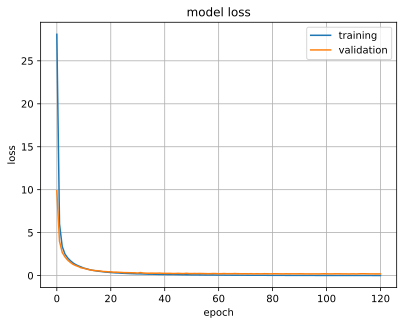

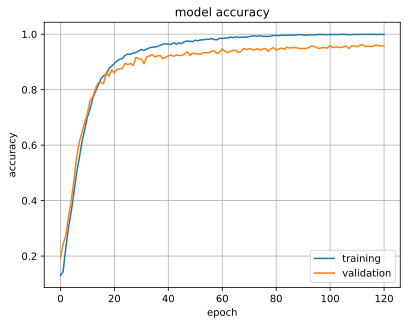

In [8]:
def plot_history(history, key):
    plt.figure()
    plt.plot(history.history[key], label='training')
    plt.plot(history.history[f'val_{key}'], label='validation')
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


plot_history(history, 'loss')
plot_history(history, 'accuracy')

The performance of the trained classifier on the validation examples is summarized in the classification report including various performance metrics

In [9]:
Y_pred = model.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        67
           1       0.96      1.00      0.98        53
           2       0.95      0.95      0.95        66
           3       0.94      0.93      0.94        55
           4       1.00      0.99      0.99        68
           5       0.95      0.98      0.97        63
           6       0.90      0.98      0.94        54
           7       0.94      0.86      0.90        59
           8       0.98      0.94      0.96        67
           9       0.92      0.92      0.92        48

    accuracy                           0.96       600
   macro avg       0.95      0.96      0.95       600
weighted avg       0.96      0.96      0.96       600



**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.